In [1]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp

import jax
import optax

from time import time
import pickle

import matplotlib.pyplot as plt

import os, sys

parent = os.path.abspath('../src')
sys.path.insert(1, parent)

from perceptron import NativePerceptron
from perceptron import Perceptron

# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


# Setting up the Problem

In [2]:
# setting up the problem
perceptron_qubits = 4
pulse_basis = 4
ts = jnp.array([1.0])
t = 1

dev = qml.device("default.qubit.jax", wires = perceptron_qubits)


perceptron =NativePerceptron(perceptron_qubits, pulse_basis, basis='gaussian', pulse_width=0.005, native_coupling=1)

H =  perceptron.H

H_obj, H_obj_spectrum = perceptron.get_1d_ising_hamiltonian(0.1)

# e_ground_state_exact = H_obj_spectrum[0]

print(f'Ising Model Hamiltonian:\nH = {H_obj}')
# print(f'Exact ground state energy: {e_ground_state_exact}')


Ising Model Hamiltonian:
H =   (0.1) [X0]
+ (0.1) [X1]
+ (0.1) [X2]
+ (0.1) [X3]
+ (1.0) [Z0 Z1]
+ (1.0) [Z1 Z2]
+ (1.0) [Z2 Z3]


I0000 00:00:1702626697.886801       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


In [3]:
perceptron.H

  (1*((PauliZ(wires=[0]) @ PauliZ(wires=[3])) + (PauliZ(wires=[1]) @ PauliZ(wires=[3])) + (PauliZ(wires=[2]) @ PauliZ(wires=[3]))))
+ (gaussian_field(params_0, t)*(PauliX(wires=[0])))
+ (gaussian_field(params_1, t)*(PauliX(wires=[1])))
+ (gaussian_field(params_2, t)*(PauliX(wires=[2])))
+ (gaussian_field(params_3, t)*(PauliX(wires=[3])))
+ (gaussian_field(params_4, t)*(PauliY(wires=[0])))
+ (gaussian_field(params_5, t)*(PauliY(wires=[1])))
+ (gaussian_field(params_6, t)*(PauliY(wires=[2])))
+ (gaussian_field(params_7, t)*(PauliY(wires=[3])))

In [4]:
V = qml.matrix(qml.evolve(H_obj, 1))

# @jax.jit
def loss(param_vector):

    param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

    U = qml.matrix(qml.evolve(perceptron.H)(param_list, t))

    return qml.math.frobenius_inner_product(jnp.conjugate(U-V),U-V).real


In [5]:
perceptron.get_random_parameter_vector(78680)

Array([0.37030671, 0.74855371, 0.58484392, 0.30983082, 0.77484652,
       0.99438136, 0.83491054, 0.11264629, 0.83207306, 0.61468838,
       0.65643422, 0.44655822, 0.78498526, 0.53200345, 0.10280592,
       0.15644964, 0.36605264, 0.0736779 , 0.14455254, 0.33163632,
       0.00733268, 0.83491699, 0.68171181, 0.52667054, 0.31613186,
       0.0353264 , 0.92591859, 0.03391787, 0.27759359, 0.6707919 ,
       0.50800882, 0.14653948], dtype=float64)

In [6]:
# getting the loss_function
# loss = get_loss_function(perceptron, ts, H_obj, dev)

param_vector = perceptron.get_random_parameter_vector(89889)

print(f'Initial parameters: {param_vector}')

print(f'Initial loss: {loss(param_vector)}')

initial_gradients = jax.grad(loss)(param_vector)
print(f'Initial gradients: {initial_gradients}')

value_and_grad = jax.jit(jax.value_and_grad(loss))

Initial parameters: [0.46277287 0.02023427 0.65881903 0.49977726 0.34659285 0.93642272
 0.34881052 0.84519349 0.42059513 0.04622494 0.72093229 0.67861117
 0.42831538 0.38050586 0.75574639 0.55465973 0.09215195 0.6589844
 0.48849394 0.7118031  0.80500511 0.41024998 0.40988453 0.19497405
 0.04221722 0.39395658 0.58721931 0.46190102 0.76075782 0.4445068
 0.88904973 0.68349988]
Initial loss: 28.774241028709216
Initial gradients: [-2.23853699 -2.9041922  -0.80616666 -1.03374559 -1.43764442 -0.75261984
 -0.35378778 -0.91399658 -3.38030671 -4.30627311 -4.02278426 -3.27852873
 -0.19575856  0.03258358  1.70297344  0.77195596 -2.28314745 -1.82325125
 -2.17049174 -1.88093428  1.38179314 -0.85307543 -1.92516539 -0.78013288
 -2.11542232 -1.46565625 -3.25393382 -4.3944746   0.72986441  1.25988289
  1.04548335  0.76985429]


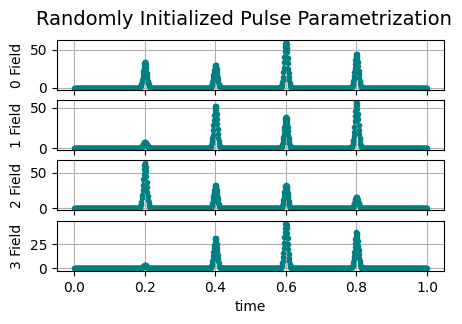

In [7]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, figsize=(5, 3), sharex=True)  # Adjusted figure size

fig.suptitle('Randomly Initialized Pulse Parametrization', fontsize=14)  # Larger title font

colors = ['teal', 'orange']  # Different colors for different plots

for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-", color='teal')
    ax.set_ylabel(f"{i} Field", fontsize=10)  # Set label with increased font size

    ax.grid(True)  # Adding gridlines

# Set label for the last plot
axs[-1].set_xlabel("time", fontsize=10)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust tight_layout to accommodate the suptitle
plt.show()


In [8]:
from datetime import datetime

n_epochs = 6000
param_vector = perceptron.get_random_parameter_vector(82)


# The following block creates a constant schedule of the learning rate
# that increases from 0.1 to 0.5 after 10 epochs
# schedule0 = optax.constant_schedule(0.1)
# schedule1 = optax.constant_schedule(0.05)
# # schedule2 = optax.constant_schedule(0.001)
# # schedule = optax.join_schedules([schedule0, schedule1, schedule2], [200, 3000])
# schedule = optax.join_schedules([schedule0, schedule1], [200])

# optimizer = optax.adam(learning_rate=schedule)

# optimizer = optax.adam(learning_rate=0.1)

optimizer = optax.sgd(learning_rate=0.005)

# optimizer = optax.sgd(learning_rate=0.005)
# optimizer = optax.adabelief(0.1)
opt_state = optimizer.init(param_vector)

energies = np.zeros(n_epochs )
# energy[0] = loss(param_vector)
mean_gradients = np.zeros(n_epochs)

gradients_trajectory = []
param_trajectory = []

# ## Compile the evaluation and gradient function and report compilation time
# time0 = time()
# _ = value_and_grad(param_vector)
# time1 = time()

# print(f"grad and val compilation time: {time1 - time0}")


## Optimization loop
for n in range(n_epochs):
    val, grads = value_and_grad(param_vector)
    updates, opt_state = optimizer.update(grads, opt_state)

    mean_gradients[n] = np.mean(np.abs(grads))
    energies[n] = val
    param_trajectory.append(param_vector)
    gradients_trajectory.append(grads)

    param_vector = optax.apply_updates(param_vector, updates)

    if not n % 10:
        print(f"{n+1} / {n_epochs}; Frobenius norm: {val}")
        print(f"    mean grad: {mean_gradients[n]}")
        print(f'    gradient norm: {jnp.linalg.norm(grads)}')
        if n>=2:
            print(f'    difference of gradients: {jnp.linalg.norm(grads-gradients_trajectory[-2])}')



print(f"Optimal Frobenius Norm Found: {energies[-1]}")


1 / 6000; Frobenius norm: 62.40253560775934
    mean grad: 1.2986866587659174
    gradient norm: 18.14253132218888
11 / 6000; Frobenius norm: 42.01031126304607
    mean grad: 0.7680038613250926
    gradient norm: 9.501424843863454
    difference of gradients: 2.4459756000416792
21 / 6000; Frobenius norm: 33.63261118218251
    mean grad: 0.8536107580574014
    gradient norm: 11.295969683941225
    difference of gradients: 1.980530087292634
31 / 6000; Frobenius norm: 30.014630614799223
    mean grad: 0.5643165775741424
    gradient norm: 7.012878149447698
    difference of gradients: 0.3524771014147276
41 / 6000; Frobenius norm: 27.77063321502678
    mean grad: 0.5165791551721357
    gradient norm: 6.421412023055251
    difference of gradients: 0.12585784111363094
51 / 6000; Frobenius norm: 25.86620782208029
    mean grad: 0.46851288086115334
    gradient norm: 5.865306526298584
    difference of gradients: 0.09897303170809363
61 / 6000; Frobenius norm: 24.325001914776983
    mean grad: 

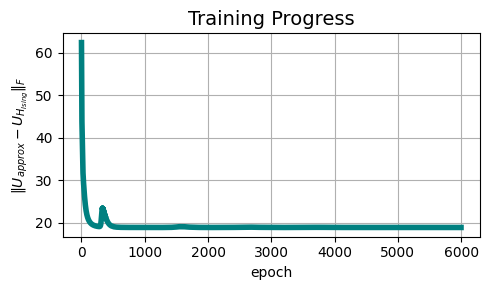

In [9]:
y = energies

fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)  # Increased the size for better visibility

ax.set_title('Training Progress', fontsize=14)  # Larger title font
ax.plot(y, color='teal', linestyle='-', linewidth=4)  # Blue line with a solid style and thicker line

ax.set_ylabel("$\| U_{approx} - U_{H_{Ising}} \|_{F}$", fontsize=10)  # Larger font for y-axis label
ax.set_xlabel("epoch", fontsize=10)  # Larger font for x-axis label

ax.grid(True)  # Adding gridlines

plt.tight_layout()
plt.show()


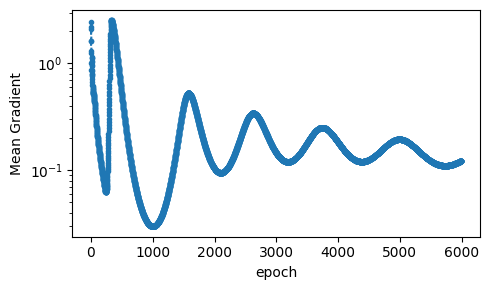

In [10]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = mean_gradients
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Mean Gradient")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

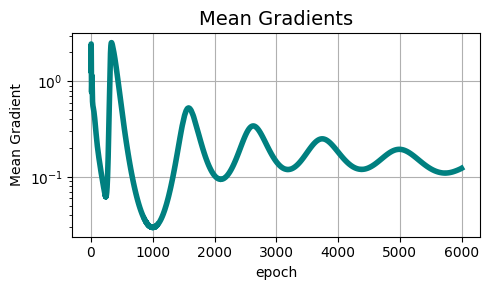

In [11]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# Plotting mean_gradients with a style similar to your example
ax.plot(mean_gradients, color='teal', linestyle='-', linewidth=4)  # Adjusted line style and color

ax.set_title('Mean Gradients', fontsize=14)  # Consistent title style
ax.set_yscale("log")  # Logarithmic y-scale
ax.set_ylabel("Mean Gradient", fontsize=10)  # Consistent y-label style
ax.set_xlabel("epoch", fontsize=10)  # Consistent x-label style

ax.grid(True)  # Adding gridlines for better readability

plt.tight_layout()
plt.show()

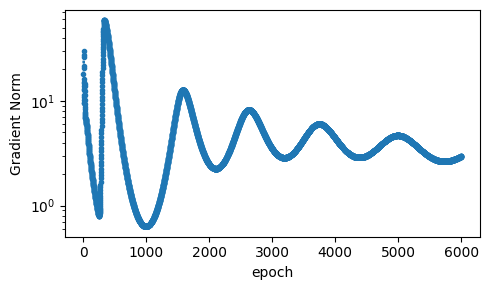

In [12]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradient) for gradient in gradients_trajectory]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Gradient Norm")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

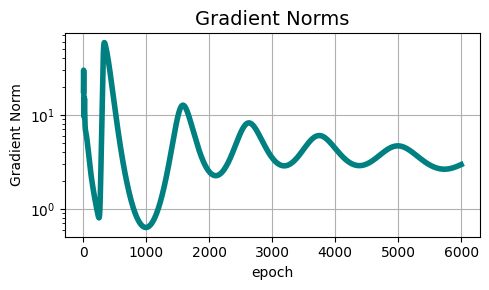

In [13]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradient) for gradient in gradients_trajectory]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, color='teal', linestyle='-', linewidth=4)  # Consistent style with previous example

ax.set_title('Gradient Norms', fontsize=14)  # Adding a title with a similar style
ax.set_yscale("log")  # Logarithmic scale for y-axis
ax.set_ylabel("Gradient Norm", fontsize=10)  # Consistent y-label style
ax.set_xlabel("epoch", fontsize=10)  # Consistent x-label style

ax.grid(True)  # Adding gridlines for readability

plt.tight_layout()
plt.show()

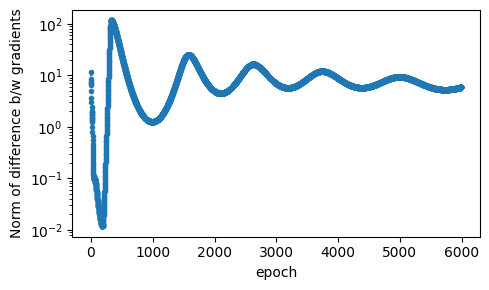

In [14]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradients_trajectory[j] - gradients_trajectory[j-1]) for j in range(1,len(gradients_trajectory))]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Norm of difference b/w gradients")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

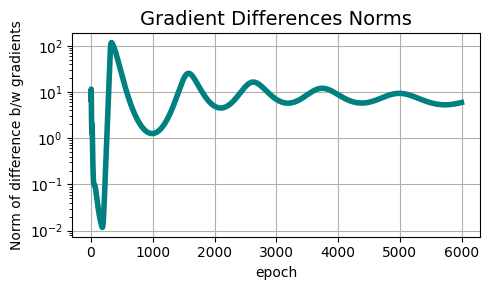

In [15]:
y = [np.linalg.norm(gradients_trajectory[j] - gradients_trajectory[j-1]) for j in range(1, len(gradients_trajectory))]

fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# Plotting the norm of difference between gradients
ax.plot(y, color='teal', linestyle='-', linewidth=4)  # Consistent style with previous examples

ax.set_title('Gradient Differences Norms', fontsize=14)  # Adding a title with a similar style
ax.set_yscale("log")  # Logarithmic scale for y-axis
ax.set_ylabel("Norm of difference b/w gradients", fontsize=10)  # Consistent y-label style
ax.set_xlabel("epoch", fontsize=10)  # Consistent x-label style

ax.grid(True)  # Adding gridlines for readability

plt.tight_layout()
plt.show()

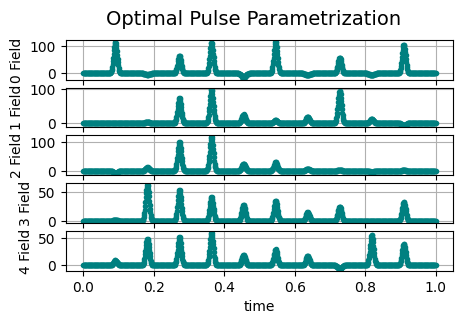

In [16]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, figsize=(5, 3), sharex=True)  # Adjusted figure size

fig.suptitle('Optimal Pulse Parametrization', fontsize=14)  # Larger title font

colors = ['teal', 'orange']  # Different colors for different plots

for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-", color='teal')
    ax.set_ylabel(f"{i} Field", fontsize=10)  # Set label with increased font size

    ax.grid(True)  # Adding gridlines

# Set label for the last plot
axs[-1].set_xlabel("time", fontsize=10)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust tight_layout to accommodate the suptitle
plt.show()


In [17]:
# Calculating the Final Hessian

final_hessian = jax.jacrev(jax.jacrev(loss))(param_vector)
final_hessian_eigenvalues = jnp.linalg.eigvals(final_hessian)
final_hessian_eigenvalues

Array([ 3.99669989e+02+0.j,  3.51744416e+02+0.j,  3.17890917e+02+0.j,
        2.95357887e+02+0.j,  2.63675883e+02+0.j,  2.83106930e+02+0.j,
        2.79475098e+02+0.j,  2.06247901e+02+0.j,  2.41160751e+02+0.j,
        2.41318007e+02+0.j,  1.54386158e+02+0.j,  1.58897481e+02+0.j,
        1.06744440e+02+0.j,  1.01240531e+02+0.j,  9.20222838e+01+0.j,
        8.25739199e+01+0.j,  8.12875497e+01+0.j,  7.19839917e+01+0.j,
        7.35936018e+01+0.j,  6.58223638e+01+0.j,  4.78148507e+01+0.j,
        1.72282791e+01+0.j,  1.34399176e+01+0.j,  1.19872739e+01+0.j,
        1.12507176e+01+0.j,  1.09884649e+01+0.j,  8.20450859e+00+0.j,
        5.18592065e+00+0.j,  4.84174257e+00+0.j,  3.71060534e+00+0.j,
        2.15988382e+00+0.j,  1.98853731e+00+0.j,  1.83686523e+00+0.j,
        1.67595107e+00+0.j, -1.15150386e+00+0.j,  1.26137637e+00+0.j,
        1.10070716e+00+0.j,  9.40366136e-01+0.j,  7.44448150e-01+0.j,
        6.76203739e-01+0.j,  4.88849947e-01+0.j,  3.81124488e-01+0.j,
       -3.81600396e-

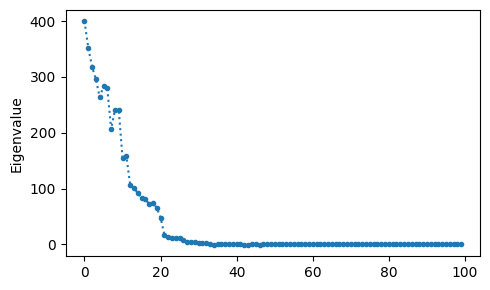

In [18]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = np.linalg.eigvals(final_hessian)

# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Eigenvalue")
# ax.set_xlabel("Eigenvalue")
# ax.legend()
y

plt.tight_layout()
plt.show()

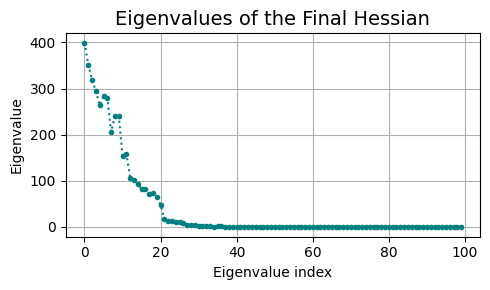

In [19]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = np.linalg.eigvals(final_hessian)

ax.plot(y, ".:", color='teal')  # Use a teal color with a dot-and-dash line style
ax.set_ylabel("Eigenvalue", fontsize=10)  # Set y-axis label with a larger font
ax.set_xlabel("Eigenvalue index", fontsize=10) 
# Uncomment the next line if a log scale is appropriate for your data
# ax.set_yscale("log")

ax.set_title("Eigenvalues of the Final Hessian", fontsize=14)  # Add a title

ax.grid(True)  # Add gridlines

plt.tight_layout()
plt.show()
